In [63]:
# lets open a netcdf l1b file
import numpy as np
import pandas as pd
import datetime as dt
import glob
from netCDF4 import Dataset
from scipy import stats
from scipy import interpolate
from scipy.optimize import fsolve, minimize
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
# from mpl_toolkits.basemap import Basemap
import gc
import sys
import copy
import imp
import SWH_tables
# import SWH_tables_J
import SWH
from numba import jit

sys.path.insert(0, '/Users/H/WAVES/SWH/')
imp.reload(SWH)
imp.reload(SWH_tables)

<module 'SWH_tables' from '/Users/H/WAVES/SWH/SWH_tables.py'>

In [ ]:
# loading a specific track SAR and psuedo LRM
# looking for 2014-03-01-06

# rads file radsdata2/c2p0145c051.asc

# processed SAR compare_tracks/CS_SWH_sig_t_A_SAR_20140301070549_20140301070825.nc

# orig file original L1B file: /cpdata/SATS/RA/CRY/cryosat_Baseline-D_TDS/L1B/SAR/2014/03/CS_TEST_SIR_SAR_1B_20140301T070514_20140301T070752_D001.nc

# processed LRM compare_tracks/CS_SWH_sig_t_A_LRM_20140301070309_20140301070548.nc

# original L1B file: /cpdata/SATS/RA/CRY/cryosat_Baseline-D_TDS/L1B/LRM/2014/03/CS_TEST_SIR_LRM_1B_20140301T070234_20140301T070514_D001.nc


In [ ]:
m_use = Basemap(projection='npstere',lon_0=0,boundinglat=45)

In [5]:
# l1b_dir = '/Volumes/BU_extra/CryoSat/L1B_nc/SAR/2014/03/'
l1b_dir = '/Users/h/WAVES/SWH/L1B_temp/'
# l1b_dir = '/Volumes/BU_extra/CryoSat/L1B_nc/LRM/2013/10/'
files = glob.glob(l1b_dir+'*.nc')
np.shape(files)

(6,)

In [6]:
file_SAR = files[0]

In [205]:
file_SAR = '/Volumes/BU_extra/CryoSat/L1B_nc/SAR/2014/03/CS_TEST_SIR_SAR_1B_20140301T070514_20140301T070752_D001.nc'
file_SARe = '/Volumes/BU_extra/CryoSat/L1B_nc/SAR/2014/03/CS_TEST_SIR_SAR_1B_20140301T002907_20140301T003024_D001.nc'
file_LRM = '../SWH_rads/compare_tracks/CS_TEST_SIR_LRM_1B_20140301T070234_20140301T070514_D001.nc'

In [ ]:
SAMOSA_dir = '../SAMOSA/results/L2_RES_DIR/'
SAMOSA_files = glob.glob(SAMOSA_dir+'*.nc')

sf = SAMOSA_files[0]

nc_o = '1Hz'
for f in SAMOSA_files[0:1]:
    f_nc = Dataset(f)
    S_lat = f_nc['latitude_'+nc_o]
    S_lon = f_nc['longitude_'+nc_o]
    S_swh = f_nc['SWH_'+nc_o]
    S_swh_std = f_nc['Std_SWH_'+nc_o]
    S_ECM_swh = f_nc['ECMWF_SWH_'+nc_o]
#     plt.plot(S_lat,S_swh)
#     plt.plot(S_lat,S_ECM_swh)
#     plt.show()
# fv = f_nc.variables
# [it[0] for it in fv.items() if ('SWH' in it[0])]

In [18]:

lon_lims = [-180,180]
lat_lims = [-90,90]
test_path = SWH.l1b_track(file_SAR,lon_lims,lat_lims,'SAR',time_open='20_ku')

In [19]:
test_path.open_echos()

In [20]:
test_path.use

False

In [35]:
# for dev - find a decent track!
# lon_lims = [-45,20]
# lat_lims = [60,78]
lon_lims = [-180,180]
# lat_lims = [60,89]
lat_lims = [-90,90]
no_wf_lim = 20
f = 0
# f = 525
use =False
while use == False:
    f += 1
    test_path = SWH.l1b_track(files[f],lon_lims,lat_lims,'SAR',time_open='20_ku')
#     test_path = SWH.l1b_track(file_SAR,lon_lims,lat_lims,'LRM',time_open='avg_01_ku')
#     test_path = SWH.l1b_track(file_SAR,lon_lims,lat_lims,'SAR',time_open='20_ku')
#     test_path = SWH.l1b_track(file_LRM,lon_lims,lat_lims,'LRM',time_open='20_ku')
    use = test_path.use
#     use = True
    if use: 
        # for dev - make sure it's of reasonable size!
        if test_path.n_p<no_wf_lim: use = False
print(f)

test_path.open_echos()
test_path.get_noise_floor()
test_path.get_peakiness()
test_path.get_power_std()
# test_path.filter_for_SWH(reduce_WF=20)
# test_path.filter_for_SWH(reduce_WF=20,LE_lim=0.7)
test_path.filter_for_SWH(reduce_WF=20,LE_lim=0.5)
# test_path.filter_for_SWH(reduce_WF=1,LE_lim=0.7)
print(test_path.n_p)

st = np.empty([test_path.lats.size])
lats2 = np.empty([test_path.lats.size])
lons2 = np.empty([test_path.lons.size])
lats2[:] = test_path.lats[:]
lons2[:] = test_path.lons[:]

160
1
160


In [ ]:
# st[:] = test_path.surf_type[1:-1]
x,y = m_use(lons2,lats2)

# m_use.scatter(x,y,c= st)
m_use.scatter(x,y)
m_use.drawcoastlines()
plt.show()

plt.plot(lons2,lats2)
plt.show()

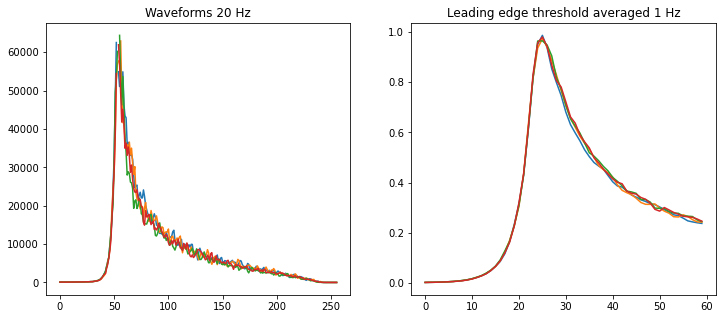

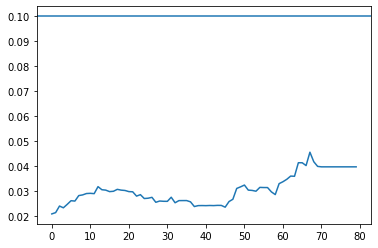

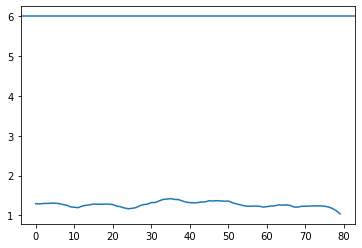

In [36]:
# quick show the waveforms
f = plt.figure(figsize=[12,5])
no_p = 8
p_s = 0.5
no_p = np.min([no_p,test_path.n_u])
plt.subplot(1,2,1)
[plt.plot(test_path.pWF[i,:] )
# [plt.plot(test_path.pWF[i,29:88] )
# [plt.plot(test_path.pWFrt[i] )
 for i in range(int(p_s*test_path.n_u),test_path.n_u,int(test_path.n_u/no_p))]
#  for i in range(1960,1990,1)]
#  for i in range(2240,2350,1)]
plt.title("Waveforms 20 Hz")
plt.subplot(1,2,2)
wave_max = np.nanmax(test_path.pWFrt)
[plt.plot(test_path.pWFrt[i]/wave_max )
 for i in range(int(p_s*test_path.n_rt),test_path.n_rt,int(test_path.n_rt/no_p))]
# # #  for i in range(2240,2245,1)]
# # #  for i in range(2240,2350,1)]
plt.title("Leading edge threshold averaged 1 Hz")
plt.show()
# f.savefig("First_SWH_201310/Waves_20131014.pdf")

plt.plot(test_path.power_std[
 int(p_s*test_path.n_u):test_path.n_u])
plt.axhline(y=0.1)
plt.show()
plt.plot(test_path.peak[
 int(p_s*test_path.n_u):test_path.n_u])
plt.axhline(y=6.0)
plt.show()

In [31]:
# load the lookup tables LRM
LU_PL_h0_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h0'
LU_PL_h2_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h2'
LU_PL_h11_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h11'
LU_PL_h12_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h12'

LRMEcho = SWH_tables.ideal_echo()
# LRMEcho.iend = 180
LRMEcho.load_tables(LU_PL_h0_f,LU_PL_h11_f,
                    LU_PL_h12_f,LU_PL_h2_f)
LRMEcho.scale = 5.5e6
LRMEcho.sampling = 1/(3.2e8) * 1e9

file = '/Users/H/WAVES/Tom_SWH/DuncanSARretracker/LRMweights.txt'
read = np.empty([128])
p = 0
LRM_f = open(file,'r')
for line in LRM_f:
    ls = line.split('    ')
    for n in ls:
        try:
            nf = float(n)
        except ValueError:
            pass
        else:
            # save them if successful
            read[p] = nf
            p +=1 
LRM_f.close()
LRMEcho.weight = read[19:79]/np.max(read)
LRMEcho.weight_s = np.sum(LRMEcho.weight)
#

# load the lookup tables SAR
LU_SAR_rec_b51_h0_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h0 V2'
LU_SAR_rec_b51_h2_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h2 V2'
LU_SAR_rec_b51_h11_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h11 V2'
LU_SAR_rec_b51_h12_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h12 V2'

# # load the lookup tables SAR
# LU_SAR_rec_b51_h0_f = '/Users/H/WAVES/Jack_SWH/SAR Rectangular 63 beams h0.mat'
# LU_SAR_rec_b51_h11_f = '/Users/H/WAVES/Jack_SWH/SAR Rectangular 63 beams h11.mat'
# LU_SAR_rec_b51_h12_f = '/Users/H/WAVES/Jack_SWH/SAR Rectangular 63 beams h12.mat'
# LU_SAR_rec_b51_h2_f = '/Users/H/WAVES/Jack_SWH/SAR Rectangular 63 beams h2.mat'

# SAREcho = SWH_tables.ideal_echo()
SAREcho = SWH_tables.ideal_echo()
SAREcho.load_tables(LU_SAR_rec_b51_h0_f,LU_SAR_rec_b51_h11_f,
                     LU_SAR_rec_b51_h12_f,LU_SAR_rec_b51_h2_f)
SAREcho.scale = 4.5e8
SAREcho.sampling = 1/(2*3.2e8) * 1e9

# open sarweights and lrmweights
file = '/Users/H/WAVES/Tom_SWH/DuncanSARretracker/SARweights.txt'
read = np.array(np.loadtxt(file))
SAREcho.weight = read[29:89]/np.max(read)
SAREcho.weight_s = np.sum(SAREcho.weight)




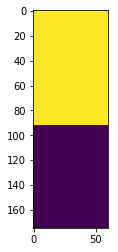

(92,)

In [208]:
# m_check = np.isnan(test_path.pWF)
m_check = np.isfinite(test_path.pWFrt)
plt.imshow(m_check)
plt.show()
# [i for i,n in enumerate(np.sum(m_check,axis=1)) if n>0]
# old_use = test_path.rt_use
# test_path.rt_use = old_use
np.shape(test_path.rt_use)

In [ ]:
SAREcho.wave_fit_mf(test_path.pWFrt[i],test_path.pwA[i],test_path.sig[i],
                       test_path.wt0[i],mode=test_path.mode)

In [37]:
# m0 = [1.0,1.0,23.0]
# test_path.get_SWH(LRMEcho,m0,method='sig_t_A',
m0 = [1.0,1.0,23.0]
test_path.get_SWH(SAREcho,m0,method='sig_t_A',
                status = 10 ,save_err=True,orbitinfo=True)

Calculating 3 parameter SWH fit
0 of 8 m = 0.9189340485941844 0.21223156763767154 23.1417834751977


/Users/H/WAVES/SWH/SWH.py:322: RuntimeWarning: divide by zero encountered in remainder
  if (np.mod(i,step) == 0) and print_status:


1 of 8 m = 0.9636717085324569 0.29097563734990756 23.34879633446776
2 of 8 m = 0.9408047524403226 0.2786384314697577 23.286542347072416
3 of 8 m = 0.9843890209918145 0.34225571674816163 23.415135586878367
4 of 8 m = 0.946145616669183 0.2792734955271534 23.195476696159872
5 of 8 m = 0.962225853249944 0.32420790696179536 23.267583178014828
6 of 8 m = 0.9719255895912681 0.3227088418214032 23.303036668524985
7 of 8 m = 0.9694844290815323 0.3050387451818949 23.265790889168898
Calculating errors


In [33]:
test_path2 = copy.copy(test_path)

In [ ]:
test_path.wt0

In [ ]:
plt.plot(test_path.latrt,test_path.sig*4)
# plt.plot(test_path.latrt,test_path.pwA)
# plt.plot(test_path.latrt,test_path.wt0)
plt.show()

In [ ]:
comp_files = glob.glob('./Compare_tracks/*')
# comp_files[0].split('t_A_')[1].split('_2014')[0]
comp_files

In [ ]:
names = []
swh_l = []
lat_l = []
for f in comp_files:
    nc = Dataset(f)
    swh_l.append(nc['swh'][:])
    lat_l.append(nc['lat'][:])
    names.append(f.split('t_A_')[1].split('_2014')[0])
    nc.close()

In [269]:
f = plt.figure(figsize=[8,8])
plt.subplot2grid([2,2],[0,0],colspan=2)
for n,s in enumerate(swh_l):
    plt.plot(lat_l[n],s)
plt.plot(S_lat,S_swh)
plt.plot(S_lat,S_ECM_swh)
plt.ylim([0,8])
plt.xlim([62,76])
plt.legend(names)

plt.subplot2grid([2,2],[1,0])
for n,s in enumerate(swh_l):
    plt.plot(lat_l[n],s)
plt.xlim([62,68])
plt.ylim([4,7])

plt.subplot2grid([2,2],[1,1])
for n,s in enumerate(swh_l):
    plt.plot(lat_l[n],s)
plt.xlim([72,76])
plt.ylim([2,5])
plt.show()
# f.savefig('Compare_prdh.pdf',bbox_inches='tight')

NameError: name 'swh_l' is not defined

In [270]:
for n,s in enumerate(swh_l):
    plt.plot(lat_l[n],s)
plt.legend(names)
plt.xlim([72,76])
plt.ylim([2,5])
plt.show()

NameError: name 'swh_l' is not defined

In [ ]:
for n,s in enumerate(swh_l):
    plt.plot(lat_l[n],s)
plt.legend(names)
plt.xlim([62,71])
plt.ylim([4,7])
plt.show()

In [255]:
full_SAR = copy.copy(test_path)

nc = Dataset('./Compare_tracks/CS_SWH_orig_sig_t_A_SAR_20140301T070549_20140301T070825.nc')
full_SAR.sig = nc['swh'][:]*0.25
full_SAR.pwA = nc['pwA'][:]
full_SAR.wt0 = nc['wt0'][:]
full_SAR.fit_err = nc['fit_error'][:]
nc.close()

In [238]:
PLRM = copy.copy(test_path)

nc = Dataset('./Compare_tracks/CS_SWH_sig_t_A_PLRM_20140301T070550_20140301T070826.nc')
PLRM.sig = nc['swh'][:]*0.25
PLRM.pwA = nc['pwA'][:]
PLRM.wt0 = nc['wt0'][:]
PLRM.fit_err = nc['fit_error'][:]
nc.close()

In [265]:
full_LRM = copy.copy(test_path)

nc = Dataset('./Compare_tracks/CS_SWH_orig_sig_t_A_LRM_20140301T070309_20140301T070548.nc')
full_LRM.sig = nc['swh'][:]*0.25
full_LRM.pwA = nc['pwA'][:]
full_LRM.wt0 = nc['wt0'][:]
full_LRM.fit_err = nc['fit_error'][:]
nc.close()

In [ ]:
# PLRM.save_swh_nc('./Compare_tracks/',LRMEcho,method='sig_t_A',
#     save_err=True,reduce_WF=1,m0=m0)

In [214]:
test_path.save_swh_nc('./Compare_tracks/',SAREcho,method='sig_t',
    save_err=True,reduce_WF=20,m0=m0)

saving in ./Compare_tracks/CS_SWH_sig_t_SAR_20140301T070549_20140301T070825.nc


In [264]:
test_path.save_swh_nc('./Compare_tracks/',LRMEcho,method='sig_t_A',
    save_err=True,reduce_WF=20,m0=m0)

saving in ./Compare_tracks/CS_SWH_sig_t_A_LRM_20140301T070309_20140301T070548.nc


In [ ]:
# full_LRM.save_swh_nc('./Compare_tracks/',LRMEcho,method='sig_t_A',
#     save_err=True,reduce_WF=20,m0=m0)

In [258]:
i=0
m0 = [1.0,1.0,23.0]
m1_PLRM = LRMEcho.wavefit_1(
                    PLRM.pWFrt[i],m0[0],m0[1],m0[2])

In [259]:
i=0
m0 = [1.0,1.0,21.0]
m1_SAR = SAREcho.wavefit_1(
                    full_SAR.pWFrt[i],m0[0],m0[1],m0[2])

In [266]:
i=0
m0 = [1.0,1.0,23.0]
m1_LRM = LRMEcho.wavefit_1(
                    full_LRM.pWFrt[i],m0[0],m0[1],m0[2])

In [233]:
m1_LRM,full_LRM.pwA[i],full_LRM.sig[i],full_LRM.wt0[i]

((1.0, 1.524659153776777, 24.0), 1.1217513, 0.71214414, 22.638224)

In [ ]:
pl.cm.cubehelix

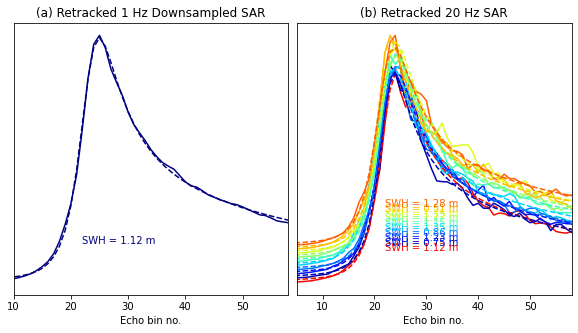

In [62]:
f = plt.figure(figsize=[10,5])
t0= 4
t1= 5
tno=1
fe_lim = 3e3
colors = pl.cm.jet(np.linspace(0,0.9,tno))
plt.subplot(1,2,1)
[plt.plot(test_path.pWFrt[tt]+tt/t1,color=colors[int((tt-t0)/(t1-t0)*tno)-1]) 
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path.fit_err[tt]<fe_lim]
[plt.plot(SAREcho.echo_vec(np.arange(60),test_path.pwA[tt],
                    test_path.sig[tt],
                    test_path.wt0[tt],
                        p=np.deg2rad(test_path.pitchrt[tt]),
                        r=np.deg2rad(test_path.rollrt[tt]),
                        delh=test_path.altrt[tt]-SAREcho.h,
                           yoff=tt/t1),
          '--',color=colors[int((tt-t0)/(t1-t0)*tno)-1])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path.fit_err[tt]<fe_lim]
plt.xlim([10,58])
plt.yticks([])
ttop = 1.2
tx = 22
[plt.text(tx,ttop*tt/t1,'SWH = '+str(round(4*test_path.sig[tt],2))+' m',#,PLRM.fit_err[tt]*1e3],
          color=colors[int((tt-t0)/(t1-t0)*tno)-1],fontsize=10)
# [print([4*PLRM.sig[tt],PLRM.fit_err[tt]*1e3])
# [print([PLRM.pwA[tt],PLRM.sig[tt], PLRM.wt0[tt]])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path.fit_err[tt]<fe_lim]
# plt.plot(SAREcho.echo_vec(np.arange(60),m1_PLRM[0],m1_PLRM[1],m1_PLRM[2]),':',color=colors[-1])

plt.xlabel('Echo bin no.')
plt.title('(a) Retracked 1 Hz Downsampled SAR')

t0*= 20
t1*= 20
tno=20
colors = pl.cm.jet(np.linspace(0,0.9,tno))
plt.subplot(1,2,2)
[plt.plot(test_path2.pWFrt[tt]+tt/t1,color=colors[int((tt-t0)/(t1-t0)*tno)-1]) 
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path2.fit_err[tt]<fe_lim]
[plt.plot(SAREcho.echo_vec(np.arange(60),test_path2.pwA[tt],
                   test_path2.sig[tt],
                   test_path2.wt0[tt],
                        p=np.deg2rad(test_path2.pitchrt[tt]),
                        r=np.deg2rad(test_path2.rollrt[tt]),
                        delh=test_path2.altrt[tt]-SAREcho.h,
                           yoff=tt/t1),
          '--',color=colors[int((tt-t0)/(t1-t0)*tno)-1])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path2.fit_err[tt]<fe_lim]
plt.xlim([5,58])
plt.yticks([])
[plt.text(tx,ttop*tt/t1,'SWH = '+str(round(4*test_path2.sig[tt],2))+' m',#,PLRM.fit_err[tt]*1e3],
          color=colors[int((tt-t0)/(t1-t0)*tno)-1],fontsize=10)
# [print([4*test_path2.sig[tt],test_path2.fit_err[tt]*1e3])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path2.fit_err[tt]<fe_lim]
# plt.plot(SAREcho.echo_vec(np.arange(60),m1_SAR[0],m1_SAR[1],m1_SAR[2]),':',color=colors[-1])
# plt.plot(LRMEcho.echo_vec(np.arange(60),0.95,0.6,23))
# plt.plot(test_vec)
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m[0],test_m[1],test_m[2]))
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m2[0],test_m2[1],test_m2[2]))
plt.xlabel('Echo bin no.')
plt.title('(b) Retracked 20 Hz SAR')
plt.subplots_adjust(wspace=0.01)

colors = pl.cm.hsv(np.linspace(0,0.8,tno))
plt.subplots_adjust(wspace=0.03)
plt.show()
f.savefig('1Hz_vs_20Hz_wavefit4.pdf',bbox_inches='tight')

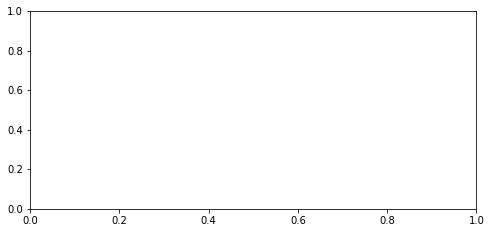

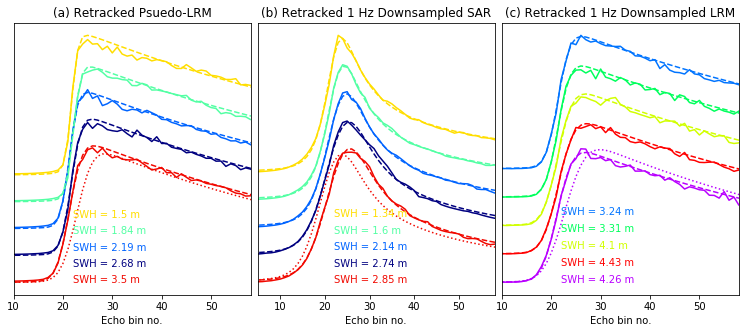

In [272]:
f = plt.figure(figsize=[13,5])
t0= 0
t1= 104
tno=5
fe_lim = 3e3
colors = pl.cm.jet(np.linspace(0,0.9,tno))
plt.subplot(1,3,1)
[plt.plot(PLRM.pWFrt[tt]+tt/t1,color=colors[int((tt-t0)/(t1-t0)*tno)-1]) 
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if PLRM.fit_err[tt]<fe_lim]
[plt.plot(LRMEcho.echo_vec(np.arange(60),PLRM.pwA[tt],
                    PLRM.sig[tt],
                    PLRM.wt0[tt],
                        p=np.deg2rad(PLRM.pitchrt[tt]),
                        r=np.deg2rad(PLRM.rollrt[tt]),
                        delh=PLRM.altrt[tt]-LRMEcho.h,
                           yoff=tt/t1),
          '--',color=colors[int((tt-t0)/(t1-t0)*tno)-1])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if PLRM.fit_err[tt]<fe_lim]
plt.xlim([10,58])
plt.yticks([])
ttop = 0.6
tx = 22
[plt.text(tx,ttop*tt/t1,'SWH = '+str(round(4*PLRM.sig[tt],2))+' m',#,PLRM.fit_err[tt]*1e3],
          color=colors[int((tt-t0)/(t1-t0)*tno)-1],fontsize=10)
# [print([4*PLRM.sig[tt],PLRM.fit_err[tt]*1e3])
# [print([PLRM.pwA[tt],PLRM.sig[tt], PLRM.wt0[tt]])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if PLRM.fit_err[tt]<fe_lim]
plt.plot(LRMEcho.echo_vec(np.arange(60),m1_PLRM[0],m1_PLRM[1],m1_PLRM[2]),':',color=colors[-1])

plt.xlabel('Echo bin no.')
plt.title('(a) Retracked Psuedo-LRM')

plt.subplot(1,3,2)
[plt.plot(full_SAR.pWFrt[tt]+tt/t1,color=colors[int((tt-t0)/(t1-t0)*tno)-1]) 
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_SAR.fit_err[tt]<fe_lim]
[plt.plot(SAREcho.echo_vec(np.arange(60),full_SAR.pwA[tt],
                    full_SAR.sig[tt],
                    full_SAR.wt0[tt],
                        p=np.deg2rad(full_SAR.pitchrt[tt]),
                        r=np.deg2rad(full_SAR.rollrt[tt]),
                        delh=full_SAR.altrt[tt]-SAREcho.h,
                           yoff=tt/t1),
          '--',color=colors[int((tt-t0)/(t1-t0)*tno)-1])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_SAR.fit_err[tt]<fe_lim]
plt.xlim([5,58])
plt.yticks([])
[plt.text(tx,ttop*tt/t1,'SWH = '+str(round(4*full_SAR.sig[tt],2))+' m',#,PLRM.fit_err[tt]*1e3],
          color=colors[int((tt-t0)/(t1-t0)*tno)-1],fontsize=10)
# [print([4*full_SAR.sig[tt],full_SAR.fit_err[tt]*1e3])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_SAR.fit_err[tt]<fe_lim]
plt.plot(SAREcho.echo_vec(np.arange(60),m1_SAR[0],m1_SAR[1],m1_SAR[2]),':',color=colors[-1])
# plt.plot(LRMEcho.echo_vec(np.arange(60),0.95,0.6,23))
# plt.plot(test_vec)
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m[0],test_m[1],test_m[2]))
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m2[0],test_m2[1],test_m2[2]))
plt.xlabel('Echo bin no.')
plt.title('(b) Retracked 1 Hz Downsampled SAR')
plt.subplots_adjust(wspace=0.01)

colors = pl.cm.hsv(np.linspace(0,0.8,tno))
plt.subplot(1,3,3)
[plt.plot(full_LRM.pWFrt[tt]+tt/t1,color=colors[int((tt-t0)/(t1-t0)*tno)-1]) 
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_LRM.fit_err[tt]<fe_lim]
[plt.plot(LRMEcho.echo_vec(np.arange(60),full_LRM.pwA[tt],
                    full_LRM.sig[tt],
                    full_LRM.wt0[tt],
                        p=np.deg2rad(full_LRM.pitchrt[tt]),
                        r=np.deg2rad(full_LRM.rollrt[tt]),
                        delh=full_LRM.altrt[tt]-LRMEcho.h,
                           yoff=tt/t1),
          '--',color=colors[int((tt-t0)/(t1-t0)*tno)-1])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_LRM.fit_err[tt]<fe_lim]
plt.xlim([10,58])
plt.yticks([])
[plt.text(tx,ttop*tt/t1,'SWH = '+str(round(4*full_LRM.sig[tt],2))+' m',#,PLRM.fit_err[tt]*1e3],
          color=colors[int((tt-t0)/(t1-t0)*tno)-1],fontsize=10)
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_LRM.fit_err[tt]<fe_lim]
plt.plot(LRMEcho.echo_vec(np.arange(60),m1_LRM[0],m1_LRM[1],m1_LRM[2]),':',color=colors[-1])
# plt.plot(LRMEcho.echo_vec(np.arange(60),0.95,0.6,23))
# plt.plot(test_vec)
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m[0],test_m[1],test_m[2]))
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m2[0],test_m2[1],test_m2[2]))
plt.xlabel('Echo bin no.')
plt.title('(c) Retracked 1 Hz Downsampled LRM')
plt.subplots_adjust(wspace=0.03)
plt.show()
# f.savefig('PLRM_vs_SAR_wavefit.pdf',bbox_inches='tight')

In [ ]:
np.nanmean(PLRM.fit_err),np.nanmean(full_SAR.fit_err),np.nanmean(full_LRM.fit_err)

In [271]:
# [print(PLRM.latrt[tt])
# for tt in range(t0,t1,int((t1-t0)/tno)+1) if PLRM.fit_err[tt]<fe_lim]
[print(full_SAR.lonrt[tt],full_SAR.latrt[tt],full_SAR.sig[tt]*4)
for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_SAR.fit_err[tt]<fe_lim]
[print(full_LRM.lonrt[tt],full_LRM.latrt[tt],full_LRM.sig[tt]*4)
for tt in range(t0,t1,int((t1-t0)/tno)+1) if full_LRM.fit_err[tt]<fe_lim]

-0.4321773142857142 71.73530763809524 2.848576545715332
-0.9426100476190475 72.86231627142857 2.741528034210205
-1.5119076428571427 73.98830368571427 2.1434082984924316
-2.153358752380952 75.11302914285713 1.5984456539154053
-2.884538938095238 76.23616940952381 1.3405214548110962
2.544886495238095 62.10498003809524 4.256983280181885
2.261851009523809 63.299154580952376 4.4250569343566895
1.9615304952380952 64.49283888095238 4.100490093231201
1.641376 65.6859941904762 3.3077564239501953
1.2983160809523808 66.87857289047622 3.243375539779663


[None, None, None, None, None]

In [ ]:
np.shape(test_path.pWFrt)

In [ ]:
f = plt.figure(figsize=[7,7])
lines = ['-r','-b','-k']
files_SAR = []
files_SAR.append('./Compare_tracks/CS_SWH_sig_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_sig_t_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_sig_t_A_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_20Hz_sig_t_A_SAR_20140301T070549_20140301T070825.nc') 
plt.subplot(4,1,1)
i=3
f_nc = Dataset(files_SAR[i])
plt.plot(f_nc['lat'],f_nc['pwA'],'.y',alpha=0.2)
for i in range(3):
    f_nc = Dataset(files_SAR[i])
    plt.plot(f_nc['lat'],f_nc['pwA'],lines[i])
plt.ylim([0.7,1.3])
# plt.xlim([0,test_path.n_u])
plt.ylabel('Wave power scale')
plt.xticks([])

plt.subplot(4,1,2)
i=3
f_nc = Dataset(files_SAR[i])
plt.plot(f_nc['lat'],f_nc['swh'],'.y',alpha=0.2)
for i in range(3):
    f_nc = Dataset(files_SAR[i])
    plt.plot(f_nc['lat'],f_nc['swh'],lines[i])
#     plt.xlim([0,test_path.n_u])
plt.ylim([0.0,4.0])
plt.ylabel('SWH meters')
plt.xticks([]) 


plt.subplot(4,1,3)
# # # plt.xlim([300,350])
i=3
f_nc = Dataset(files_SAR[i])
plt.plot(f_nc['lat'],f_nc['wt0'],'.y',alpha=0.2)
for i in range(3):
    f_nc = Dataset(files_SAR[i])
    plt.plot(f_nc['lat'],f_nc['wt0'],lines[i])
plt.ylim([21,29.0])
# plt.xlim([0,test_path.n_u])
plt.ylabel('Leading edge offset')
# plt.xticks([])

plt.subplot(4,1,4)
i=3
f_nc = Dataset(files_SAR[i])
plt.plot(f_nc['lat'],f_nc['fit_error'],'.y',alpha=0.2)
for i in range(3):
    f_nc = Dataset(files_SAR[i])
    plt.plot(f_nc['lat'],f_nc['fit_error'],lines[i])
plt.yscale('log')
plt.ylim([1e-4,1e-2])
# plt.xlim([0,test_path.n_u])
plt.ylabel('Wave fit error')
plt.xlabel('Latitude')
plt.show()

# f.savefig('First_SWH_3param_compare20Hz_1Hz.pdf')


1.0 0.0008535296
1.0 0.00024004854
1.0204949 0.00043312964


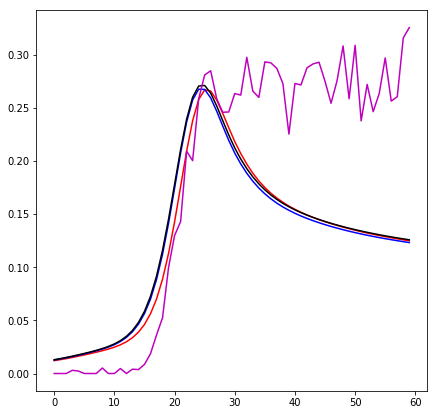

In [248]:
f = plt.figure(figsize=[7,7])
lines = ['-r','-b','-k']
files_SAR = []
files_SAR.append('./Compare_tracks/CS_SWH_sig_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_sig_t_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_orig_sig_t_A_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_20Hz_sig_t_A_SAR_20140301T070549_20140301T070825.nc') 
i=3
# tt = 47
f_nc = Dataset(files_SAR[i])
for i in range(3):
    f_nc = Dataset(files_SAR[i])
    plt.plot(SAREcho.echo_vec(np.arange(60),f_nc['pwA'][tt],
                    f_nc['swh'][tt]/4,f_nc['wt0'][tt],
                        p=np.deg2rad(test_path.pitchrt[tt]),
                        r=np.deg2rad(test_path.rollrt[tt]),
                        delh=test_path.altrt[tt]-SAREcho.h,
                             )*SAREcho.weight,lines[i])
    print(f_nc['pwA'][tt],f_nc['fit_error'][tt])
plt.plot(test_path.pWFrt[tt]*SAREcho.weight,'m')
# plt.plot(SAREcho.weight)
plt.show()

# f.savefig('First_SWH_3param_compare20Hz_1Hz.pdf')


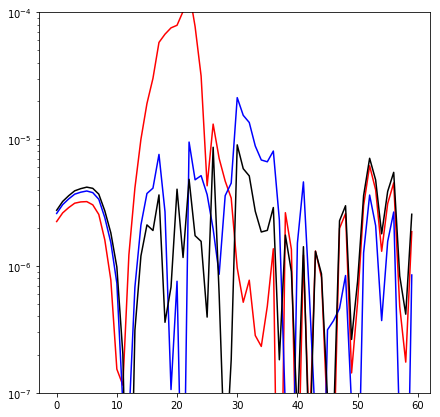

In [203]:
f = plt.figure(figsize=[7,7])
lines = ['-r','-b','-k']
files_SAR = []
files_SAR.append('./Compare_tracks/CS_SWH_sig_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_sig_t_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_sig_t_A_SAR_20140301T070549_20140301T070825.nc') 
files_SAR.append('./Compare_tracks/CS_SWH_20Hz_sig_t_A_SAR_20140301T070549_20140301T070825.nc') 
i=3
# tt = 5
f_nc = Dataset(files_SAR[i])
for i in range(3):
    f_nc = Dataset(files_SAR[i])
    plt.plot(SAREcho.wave_fit_mf(test_path.pWFrt[tt],f_nc['pwA'][tt],
                    f_nc['swh'][tt]/4,f_nc['wt0'][tt],
                        p=np.deg2rad(test_path.pitchrt[tt]),
                        r=np.deg2rad(test_path.rollrt[tt]),
                        delh=test_path.altrt[tt]-SAREcho.h,
                                 return_vec=True)[1],lines[i])
# plt.plot(SAREcho.weight)
plt.yscale('log')
plt.ylim([1e-7,1e-4])
plt.show()

# f.savefig('First_SWH_3param_compare20Hz_1Hz.pdf')


In [ ]:
g = lambda x: SAREcho.wave_fit_mf(test_path.pWFrt[tt],x[0],x[1],x[2],p,r,delh,error_return = 1e1,mode='SAR')


In [ ]:
plt.plot(SAREcho.weight)
plt.show()

In [ ]:
p_lim = 4.0 
p_std = 0.07
w_use = [18,78]
LE0 = 40
LE_l = 86
reduce_WF = 20
LE_lim = 0.7
n_rWF = int(test_path.n_u/reduce_WF)
test_path.n_rt = n_rWF
test_path.pWFrt = np.empty([n_rWF,60])
test_path.lonrt = np.empty([n_rWF])
test_path.latrt = np.empty([n_rWF])
#extra info to average times
test_path.timesrt = np.empty([n_rWF])
day0 = dt.datetime(2000,1,1)
day0_secs = day0.timestamp()
for i in range(n_rWF):
    # reduce elements i*rWF:(i+1)*rWF
    # only if rt_mask says so
    # and move WF to leading edge
    wf_use = [reduce_WF*i + j 
        for j,n in enumerate(test_path.rt_mask[reduce_WF*i:reduce_WF*(i+1)+1]) if n]
    LE_t= [SWH.find_LE(test_path.pWF[j],LE_lim) 
            for j in wf_use]
    # if leading edge is too early or late - delete this wave from wf_use
#     wf_use = [j for k,j in enumerate(wf_use) 
#      if (w_use[0]+LE_t[k]-LE0>1)and(w_use[1]+LE_t[k]-LE0<127)]
#     LE_t = [j for j in LE_t
#      if (w_use[0]+j-LE0>1)and(w_use[1]+j-LE0<127)]  
#     del_list=[]
#     for k,j in enumerate(wf_use):
#         if w_use[0]+LE_t[k]-LE0<1: del_list.append(k)
#         if w_use[1]+LE_t[k]-LE0>127: del_list.append(k)
    LE_av = np.mean([test_path.pWF[j,w_use[0]+LE_t[k]-LE0:w_use[1]+LE_t[k]-LE0]
            for k,j in enumerate(wf_use)
            # extra check to avoid those outside a sensible window to Leading edges
            if (w_use[0]+LE_t[k]-LE0>1)and(w_use[1]+LE_t[k]-LE0<127)],axis=0)

In [ ]:
[j for k,j in enumerate(wf_use) 
     if (w_use[0]+LE_t[k]-LE0>1)and(w_use[1]+LE_t[k]-LE0<127)]

In [ ]:
wf_use,LE_t

In [ ]:
[j for j in LE_t
     if (w_use[0]+j-LE0>1)and(w_use[1]+j-LE0<127)]

In [ ]:
# load the lookup tables LRM
LU_PL_h0_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h0'
LU_PL_h2_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h2'
LU_PL_h11_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h11'
LU_PL_h12_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h12'

LRMEcho = SWH_tables.ideal_echo()
LRMEcho.load_tables(LU_PL_h0_f,LU_PL_h11_f,
                    LU_PL_h12_f,LU_PL_h2_f)
LRMEcho.scale = 5.5e6
LRMEcho.sampling = 1/(3.2e8) * 1e9

file = '/Users/H/WAVES/Tom_SWH/DuncanSARretracker/LRMweights.txt'
read = np.empty([128])
p = 0
LRM_f = open(file,'r')
for line in LRM_f:
    ls = line.split('    ')
    for n in ls:
        try:
            nf = float(n)
        except ValueError:
            pass
        else:
            # save them if successful
            read[p] = nf
            p +=1 
LRM_f.close()
LRMEcho.weight = read[19:79]/np.max(read)
LRMEcho.weight_s = np.sum(LRMEcho.weight)
#

In [ ]:
# load the lookup tables SAR
LU_SAR_rec_b51_h0_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h0 V2'
LU_SAR_rec_b51_h2_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h2 V2'
LU_SAR_rec_b51_h11_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h11 V2'
LU_SAR_rec_b51_h12_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h12 V2'

SAREcho = SWH_tables.ideal_echo()
SAREcho.load_tables(LU_SAR_rec_b51_h0_f,LU_SAR_rec_b51_h11_f,
                     LU_SAR_rec_b51_h12_f,LU_SAR_rec_b51_h2_f)
SAREcho.scale = 4.5e8
SAREcho.sampling = 1/(2*3.2e8) * 1e9

# open sarweights and lrmweights
file = '/Users/H/WAVES/Tom_SWH/DuncanSARretracker/SARweights.txt'
read = np.array(np.loadtxt(file))
SAREcho.weight = read[29:89]/np.max(read)
SAREcho.weight_s = np.sum(SAREcho.weight)


In [ ]:
test_path.get_SWH(SAREcho,[1.0,0.1,28.0],method='sig_t_A',
                status = 10 ,save_err=True)

In [ ]:
f = plt.figure(figsize=[7,7])
plt.subplot(4,1,1)
itot=1
i=itot
# plt.plot(wf_no[i],A_f[i],'.y',alpha=0.2)
# [plt.plot(wf_no[i],A_f[i],lines[i]) for i in range(itot)]
plt.plot(test_path.timesrt,test_path.pwA)
# plt.ylim([0.8,1.2])
# plt.xlim([0,test_path.n_u])
plt.ylabel('Wave power scale')
plt.xticks([])

plt.subplot(4,1,2)
i=3
# plt.plot(wf_no[i],sig[i]*4,'.y',alpha=0.2)
# [plt.plot(wf_no[i],sig[i]*4,lines[i]) for i in range(itot)]
plt.plot(test_path.timesrt,test_path.sig*4)
# plt.ylim([0,2.5])
# plt.ylim([0.3,1.0])
# plt.ylim([0.0,4.0])
# plt.xlim([0,test_path.n_u])
plt.ylabel('SWH meters')
plt.xticks([])

plt.subplot(4,1,3)
# # plt.xlim([300,350])
i=3
# plt.plot(wf_no[i],t_0[i],'.y',alpha=0.2)
# [plt.plot(wf_no[i],t_0[i],lines[i]) for i in range(itot)]
plt.plot(test_path.timesrt,test_path.wt0)
plt.ylim([25,29.0])
# plt.xlim([0,test_path.n_u])
plt.ylabel('Leading edge offset')
plt.xticks([])

plt.subplot(4,1,4)
i=3
# plt.plot(wf_no[i],fit_err[i],'.y',alpha=0.2)
# [plt.plot(wf_no[i],fit_err[i],lines[i]) for i in range(itot)]
plt.plot(test_path.timesrt,test_path.fit_err)
plt.ylim([0,0.001])
# plt.xlim([0,test_path.n_u])
plt.ylabel('Wave fit error')
plt.xlabel('Waveform number')
plt.show()

# f.savefig('First_SWH_3param_compare20Hz_1Hz.pdf')


In [ ]:
directory = '/Volumes/BU_extra/CryoSat/SWH/LRM_nc/2013/10/'
test_path.save_swh_nc(directory,LRMEcho,method='sig_t_A',
    save_err=True,reduce_WF=20,m0=[1.0,0.1,28.0])

In [ ]:
i = 301
test_m = LRMEcho.wavefit_3(test_path.pWFrt[i],
                              1.0,0.1,28.0)
test_vec = LRMEcho.echo_vec(np.arange(60),test_m[0],test_m[1],test_m[2])
test_m

In [ ]:
int((431-t0)/(t1-t0)*tno)-1

In [ ]:
t0= 0
t1= 434
tno=124
fe_lim = 3e-3
colors = pl.cm.jet(np.linspace(0,1,tno))
[plt.plot(test_path.pWFrt[tt],color=colors[int((tt-t0)/(t1-t0)*tno)-1]) 
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path.fit_err[tt]<fe_lim]
[plt.plot(SAREcho.echo_vec(np.arange(60),test_path.pwA[tt],test_path.sig[tt],test_path.wt0[tt]),
          '--',color=colors[int((tt-t0)/(t1-t0)*tno)-1])
 for tt in range(t0,t1,int((t1-t0)/tno)+1) if test_path.fit_err[tt]<fe_lim]
# plt.plot(LRMEcho.echo_vec(np.arange(60),0.95,0.6,23))
# plt.plot(test_vec)
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m[0],test_m[1],test_m[2]))
# plt.plot(LRMEcho.echo_vec(np.arange(60),test_m2[0],test_m2[1],test_m2[2]))
plt.show()

In [ ]:

temp = np.ma.array(test_path.pWF,mask=test_path.over_nf)
# test_path.peaky = np.max(temp.data,axis = 1)*np.sum(test_path.over_nf,axis=1)/np.sum(temp,axis = 1)

plt.plot(test_path.peaky)
plt.plot(test_path.peak)
plt.show()
plt.plot(np.max(temp.data,axis = 1)*np.sum(test_path.over_nf,axis=1)/1e6)
# plt.plot(temp[-5])
plt.show()
plt.plot(np.sum(temp,axis = 1)/1e6)
plt.show()

In [ ]:
# for dev - find a decent track!
lon_lims = [-180,180]
lat_lims = [60,89]
f = 445
# f = 525
lons_long = []
lats_long = []
sig_long = []
save_dir ='/Users/H/WAVES/SWH/First_SWH_201310/' 


f_tot = np.shape(files)[0]
use =False
# for f in range(1000):
for f in range(5):
    test_path = l1b_track(files[f],lon_lims,lat_lims,'SAR',time_open='20_ku')
    use = test_path.use
    if use: 
        # for dev - make sure it's of reasonable size!
#         if test_path.n_p<no_wf_lim: use = False

        print('file',f,'of',f_tot,'waves to use =',test_path.n_p)
        test_path.open_echos()
        test_path.get_noise_floor()
        test_path.get_peakiness()
        test_path.get_power_std()
        # test_path.filter_for_SWH('SAR')
        # test_path.filter_for_SWH(reduce_WF=20)
        test_path.filter_for_SWH(reduce_WF=20)
        print('calculating SWH')
        test_path.get_SWH(SAREcho,[1.0,1.0,28.0],method='sig_t_A',
                status = 2 ,save_err=True)
        # save the file
        save_file = test_path.times[0].strftime('%Y%m%d%X')+'_SWH_first_sigAt.npz'
        print(save_file)
        np.savez(save_file,
            lon=test_path.lonrt,lat=test_path.latrt,
            pwA=test_path.pwA,sig=test_path.sig,wt0=test_path.wt0,
            fit_err=test_path.fit_err)
        
        # append important info
        [lons_long.append(i) for i in test_path.lonrt]
        [lats_long.append(i) for i in test_path.latrt]
        [sig_long.append(i) for i in test_path.sig]
        
        del test_path.pWF
        del test_path.pWFrt
        del test_path
        gc.collect()
        
        

In [ ]:
np.shape(sig_long),8200/20,2220/20

In [ ]:
plt.plot(test_path.pWFrt[0,:])
plt.show()

In [ ]:
%timeit(number=1) test_path.get_SWH([1.0,1.0,28.0],method='sig_t_A',status = False ,save_err=True)


In [ ]:
A_f.append(test_path.pwA)
sig.append(test_path.sig)
t_0.append(test_path.wt0)
fit_err.append(test_path.fit_err)
wf_no.append(np.linspace(0,test_path.n_u,test_path.n_rt))

In [ ]:
np.savez('First_SWH_3param_compare1Hz_20Hz.npz',
         A_f=A_f,sig=sig,t_0=t_0,fit_err=fit_err)

In [ ]:
lines = ['-r','-b','-k','.k']

In [ ]:
f = plt.figure(figsize=[7,7])
plt.subplot(4,1,1)
i=3
plt.plot(wf_no[i],A_f[i],'.y',alpha=0.2)
[plt.plot(wf_no[i],A_f[i],lines[i]) for i in range(3)]
plt.ylim([0.8,1.2])
plt.xlim([0,test_path.n_u])
plt.ylabel('Wave power scale')
plt.xticks([])

plt.subplot(4,1,2)
i=3
plt.plot(wf_no[i],sig[i]*4,'.y',alpha=0.2)
[plt.plot(wf_no[i],sig[i]*4,lines[i]) for i in range(3)]
# plt.ylim([0,2.5])
# plt.ylim([0.3,1.0])
plt.ylim([1.0,4.0])
plt.xlim([0,test_path.n_u])
plt.ylabel('SWH meters')
plt.xticks([])

plt.subplot(4,1,3)
# # plt.xlim([300,350])
i=3
plt.plot(wf_no[i],t_0[i],'.y',alpha=0.2)
[plt.plot(wf_no[i],t_0[i],lines[i]) for i in range(3)]
plt.ylim([27,29.0])
plt.xlim([0,test_path.n_u])
plt.ylabel('Leading edge offset')
plt.xticks([])

plt.subplot(4,1,4)
i=3
plt.plot(wf_no[i],fit_err[i],'.y',alpha=0.2)
[plt.plot(wf_no[i],fit_err[i],lines[i]) for i in range(3)]
plt.ylim([0,0.003])
plt.xlim([0,test_path.n_u])
plt.ylabel('Wave fit error')
plt.xlabel('Waveform number')
plt.show()

# f.savefig('First_SWH_3param_compare20Hz_1Hz.pdf')


In [ ]:
f = plt.figure(figsize=[7,7])
plt.subplot(4,1,1)
[plt.plot(wf_no[i],A_f[i]) for i in range(3)]
i=3
plt.plot(wf_no[i],A_f[i],'.g',alpha=0.5)
plt.ylim([0.8,1.2])
plt.xlim([0,test_path.n_u])
plt.ylabel('Wave power scale')

plt.subplot(4,1,2)
[plt.plot(wf_no[i],sig[i]) for i in range(3)]
i=3
plt.plot(wf_no[i],sig[i],'.g',alpha=0.5)
# plt.ylim([0,2.5])
plt.ylim([0.3,1.0])
plt.xlim([0,test_path.n_u])
plt.ylabel('Sigma = SWH/4')

plt.subplot(4,1,3)
# # plt.xlim([300,350])
[plt.plot(wf_no[i],t_0[i]) for i in range(3)]
i=3
plt.plot(wf_no[i],t_0[i],'.g',alpha=0.5)
plt.ylim([27,28.5])
plt.xlim([0,test_path.n_u])
plt.ylabel('Leading edge offset')

plt.subplot(4,1,4)
[plt.plot(wf_no[i],fit_err[i]) for i in range(3)]
i=3
plt.plot(wf_no[i],fit_err[i],'.g',alpha=0.5)
# plt.ylim([27,28.5])
plt.xlim([0,test_path.n_u])
plt.ylabel('Wave fit error')
plt.show()

f.savefig('First_SWH_3param_compare20Hz_1Hz.pdf')


In [ ]:
# plt.plot(test_path.nf)
plt.plot(test_path.peaky)
plt.plot(test_path.peak)
# plt.plot(np.sum(test_path.over_nf,axis=1))
# plt.plot(test_path.power_std)
# plt.plot(peak)
# plt.plot(2.0**test_path.eSP)
# plt.xlim([2240,2350])
plt.show()

In [ ]:
LU_PL_h0_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h0'
LU_PL_h2_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h2'
LU_PL_h11_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h11'
LU_PL_h12_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/PL h12'
LU_SAR_rec_b51_h0_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h0 V2'
LU_SAR_rec_b51_h2_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h2 V2'
LU_SAR_rec_b51_h11_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h11 V2'
LU_SAR_rec_b51_h12_f = '/Users/H/WAVES/SWH/Lookup_tables/Original/SAR Rectangular 51 beams h12 V2'

In [ ]:
SAREcho = SWH.ideal_echo()
LRMEcho = SWH.ideal_echo()
SAREcho.load_tables(LU_SAR_rec_b51_h0_f,LU_SAR_rec_b51_h11_f,
                     LU_SAR_rec_b51_h12_f,LU_SAR_rec_b51_h2_f)
LRMEcho.load_tables(LU_PL_h0_f,LU_PL_h11_f,
                    LU_PL_h12_f,LU_PL_h2_f)

In [ ]:
sig =0.3
plt.plot(np.linspace(-50,140),[SAREcho.echo(0,i,0,0,0) for i in np.linspace(-50,140)])
plt.show()

In [ ]:
i =20
sampling = 1/(2*320000000) * 1e9
t0 = 28.0
# t0 = 22.0
np.shape(test_path.pWFrt[i])
plt.plot(test_path.pWFrt[i]/np.max(test_path.pWFrt[i]))
plt.plot(np.linspace(1,60),[1.1*4.5e8*SAREcho.echo(0.9,(t-t0)*sampling,0,0,0) for t in np.linspace(1,60)])
plt.show()

In [ ]:
# open sarweights and lrmweights
file = '/Users/H/WAVES/Tom_SWH/DuncanSARretracker/SARweights.txt'
read = np.array(np.loadtxt(file))
SARw = read[29:89]/np.max(read)
SARws=np.sum(SARw)
file = '/Users/H/WAVES/Tom_SWH/DuncanSARretracker/LRMweights.txt'
read = np.empty([128])
p = 0
LRM_f = open(file,'r')
for line in LRM_f:
    ls = line.split('    ')
    for n in ls:
        try:
            nf = float(n)
        except ValueError:
            pass
        else:
            # save them if successful
            read[p] = nf
            p +=1 
LRM_f.close()
LRMw = read[19:79]/np.max(read)
LRMwS=np.sum(LRMw)
#
# plt.plot(LRMw)
# plt.plot(SARw)
# plt.show()
# LRMwS,SARwS

# this fits sig, but leaves the leading edge - tor0, and scale factor - As constant
# do we need to do all 3?
def SAR_wave_fit_mf(wf,A,sig,t0,return_vec = False,error_return = np.nan):
    """
    takes an input waveform and returns a misfit to an idealised waveform
    wf is the input waveform
    idealised given by power A, shape sig, leading edge t0
    the weighting function is presupplied
    normally returns a float that is the magnitude of mf (so to be minimised)
    return_vec for diagnostic, so to see the shape of the misfit
        the x vec, and corresponding vector of difference returned.
    """
    scale = 4.5e8
    sampling = 1/(2*3.2e8) * 1e9
    # get the shape of the waveform
    wf_s = np.shape(wf)
    # make x vec that corresponds
    x_vec = np.linspace(0,wf_s[0]-1,wf_s[0])
    diff_vec = wf - [A*scale*SAREcho.echo(sig,(t-t0)*sampling,0,0,0,error_return = error_return) for t in x_vec]
    diff_vec = SARw/SARws*diff_vec**2
    if return_vec:
        return x_vec, diff_vec
    else:
        return np.nansum(diff_vec)

def LRM_wave_fit_mf(wf,A,sig,t0,return_vec = False,error_return = np.nan):
    """
    takes an input waveform and returns a misfit to an idealised waveform
    wf is the input waveform
    idealised given by power A, shape sig, leading edge t0
    the weighting function is presupplied
    normally returns a float that is the magnitude of mf (so to be minimised)
    return_vec for diagnostic, so to see the shape of the misfit
        the x vec, and corresponding vector of difference returned.
    """
    scale = 4.5e8
    sampling = 1/(2*3.2e8) * 1e9
    # get the shape of the waveform
    wf_s = np.shape(wf)
    # make x vec that corresponds
    x_vec = np.linspace(0,wf_s[0]-1,wf_s[0])
    diff_vec = wf - [A*scale*LRMEcho.echo(sig,(t-t0)*sampling,0,0,0,error_return = error_return) for t in x_vec]
    diff_vec = LRMw/LRMws*diff_vec**2
    if return_vec:
        return x_vec, diff_vec
    else:
        return np.nansum(diff_vec)
     

In [ ]:
i = 200
test_n = 4
path_3 = np.empty([test_n,4])
path_1 = np.empty([test_n,2])

step = np.int(test_n/10)

def SAR_wavefit_1(wf,A0,sig0,t0):
    g = lambda x: SAR_wave_fit_mf(wf,A0,x[0],t0,error_return = 1e1)
    result = minimize(g, [sig0],bounds=[(0.0,2.5)],
                      tol=1e-7,method='L-BFGS-B')
    return A0,result.x[0],t0

def SAR_wavefit_2(wf,A0,sig0,t0):
    g = lambda x: SAR_wave_fit_mf(wf,A0,x[0],x[1],error_return = 1e1)
    result = minimize(g, [sig0,t0],bounds=[(0.0,2.5),(20.0,40.0)],
                      tol=1e-7,method='L-BFGS-B')
    return A0,result.x[0],result.x[1]

# @jit
def SAR_wavefit_3(wf,A0,sig0,t0):
    g = lambda x: SAR_wave_fit_mf(wf,x[0],x[1],x[2],error_return = 1e1)
    result = minimize(g, [A0,sig0,t0],bounds=[(0.5,1.5),(0.0,2.5),(10.0,40.0)],
                      tol=1e-7,method='L-BFGS-B')
    return result.x[0],result.x[1],result.x[2]

def LRM_wavefit_1(wf,A0,sig0,t0):
    g = lambda x: LRM_wave_fit_mf(wf,A0,x[0],t0,error_return = 1e1)
    result = minimize(g, [sig0],bounds=[(0.0,2.5)],
                      tol=1e-7,method='L-BFGS-B')
    return A0,result.x[0],t0

def LRM_wavefit_2(wf,A0,sig0,t0):
    g = lambda x: LRM_wave_fit_mf(wf,A0,x[0],x[1],error_return = 1e1)
    result = minimize(g, [sig0,t0],bounds=[(0.0,2.5),(20.0,40.0)],
                      tol=1e-7,method='L-BFGS-B')
    return A0,result.x[0],result.x[1]

# @jit
def LRM_wavefit_3(wf,A0,sig0,t0):
    g = lambda x: LRM_wave_fit_mf(wf,x[0],x[1],x[2],error_return = 1e1)
    result = minimize(g, [A0,sig0,t0],bounds=[(0.5,1.5),(0.0,2.5),(10.0,40.0)],
                      tol=1e-7,method='L-BFGS-B')
    return result.x[0],result.x[1],result.x[2]

path_3 = np.empty([test_n,4])
for i in range(test_n):
    path_3[i,0:3] = SAR_wavefit_3(test_path.pWFrt[i],1.0,1.0,28.0)
    path_3[i,3] = SAR_wave_fit_mf(test_path.pWFrt[i],path_3[i,0],path_3[i,1],path_3[i,2])
    if np.mod(i,step) == 0:
        print(i,'of',test_n,'m =',path_3[i])

In [ ]:
%timeit SWH_wavefit_3(test_path.pWFrt[i],1.0,1.0,28.0)

In [ ]:
i = 200
test_n = 4
path_3 = np.empty([test_n,4])
path_1 = np.empty([test_n,2])

step = np.int(test_n/10)
for i in range(test_n):
    g = lambda x: SAR_wave_fit_mf(test_path.pWFrt[i],1,x[0],20,error_return = 1e1)
    result = minimize(g, [1.0],bounds=[(0.0,2.5)],
                      tol=1e-5,method='L-BFGS-B')
    path_1[i,0] = result.x[0]
    path_1[i,1] = SAR_wave_fit_mf(test_path.pWFrt[i],1,result.x[0],30)
    g = lambda x: SAR_wave_fit_mf(test_path.pWFrt[i],x[0],x[1],x[2],error_return = 1e1)
    result = minimize(g, [1.0,1.0,28.0],bounds=[(0.5,1.5),(0.0,2.5),(10.0,40.0)],
                      tol=1e-7,method='L-BFGS-B')
    path_3[i,0:3] = result.x[:]
    path_3[i,3] = SAR_wave_fit_mf(test_path.pWFrt[i],result.x[0],result.x[1],result.x[2])
    if np.mod(i,step) == 0:
        print(i,'of',test_n,'m =',result.x,'err = ',path_3[i,3])

In [ ]:
test_path.pWFrt[i]

In [ ]:
i = 2245
i = 25

# g = lambda x: SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,1,x[0],30,error_return = 1e1)
# x0 = fsolve(g, [1.0])
# print(x0)
# print(SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,1,x0[0],30))
g = lambda x: SAR_wave_fit_mf(test_path.pWFrt[i],1,x[0],30,error_return = 1e1)
result = minimize(g, [1.0],bounds=[(0.0,2.5)],tol=1e-6)
print(result.x)
x0 = result.x
print(SAR_wave_fit_mf(test_path.pWFrt[i],1,result.x[0],30))
g = lambda x: SAR_wave_fit_mf(test_path.pWFrt[i],x[0],x[1],x[2],error_return = 1e1)
result = minimize(g, [1.0,1.0,30.0],bounds=[(0.5,1.5),(0.0,2.5),(10.0,40.0)],tol=1e-6)
print(result.x)
print(SAR_wave_fit_mf(test_path.pWFrt[i],result.x[0],result.x[1],result.x[2]))


In [ ]:
# i = 2245

g = lambda x: SAR_wave_fit_mf(test_path.pWFrt[i],x[0],x[1],x[2],error_return = 1e1)
%timeit result = minimize(g, [1.0,1.0,30.0],bounds=[(0.5,1.5),(0.0,2.5),(10.0,40.0)],tol=1e-6)
print(result.x)
print(SAR_wave_fit_mf(test_path.pWFrt[i],result.x[0],result.x[1],result.x[2]))
%timeit result = minimize(g, [1.0,1.0,30.0],bounds=[(0.5,1.5),(0.0,2.5),(10.0,40.0)],tol=1e-6,method='L-BFGS-B')
print(result.x)
print(SAR_wave_fit_mf(test_path.pWFrt[i],result.x[0],result.x[1],result.x[2]))


In [ ]:
# i =200
t0 = 30
plt.plot(test_path.pWFrt[i])
plt.plot(np.linspace(1,60),[4.5e8*SAREcho.echo(x0[0],(t-t0)*sampling,0,0,0) for t in np.linspace(1,60)])
t0 = result.x[2]
plt.plot(np.linspace(1,60),[result.x[0]*4.5e8*SAREcho.echo(result.x[1],(t-t0)*sampling,0,0,0) for t in np.linspace(1,60)])
plt.show()

In [ ]:
path_var = [SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,path_sig[i,0],path_sig[i,1],path_sig[i,2]) for i in range(0,test_n)]

In [ ]:
path_var = [SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,1,path_sig[i],30) for i in range(0,test_n)]

In [ ]:
path_var = [SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,path_sig) for i in range(0,test_n)]

In [ ]:
plt.plot(path_1[:,0],'.r',alpha = 0.5)
plt.plot(savgol_filter(path_1[:,0],19,3),'-r',alpha=0.7)
plt.plot(path_3[:,1],'.b',alpha = 0.5)
plt.plot(savgol_filter(path_3[:,1],19,3),'-b')
# plt.ylim([0,2.5])
plt.ylim([0.5,1.2])
# plt.xlim([300,350])
plt.show()
plt.plot(path_3[:,0],'.b',alpha = 0.5)
plt.plot(savgol_filter(path_3[:,0],19,3),'-b')
# plt.ylim([0,2.5])
plt.ylim([0.8,1.2])
plt.show()
plt.plot(path_3[:,2],'.b',alpha = 0.5)
plt.plot(savgol_filter(path_3[:,2],19,3),'-b')
# plt.ylim([0,2.5])
plt.ylim([28.0,32.0])
plt.show()
plt.plot(path_1[:,1]*1e3,'.r',alpha = 0.5)
plt.plot(path_3[:,3]*1e3,'.b',alpha = 0.5)
plt.plot(savgol_filter(path_3[:,3]*1e3,9,3),'-b')
# plt.plot(path_1[:,1]*1e3)
# plt.plot(path_3[:,3]*1e3)
# plt.xlim([300,350])
plt.show()

In [ ]:
plt.plot(path_sig)
plt.ylim([0,2.5])
plt.show()
plt.plot(path_var)
plt.show()

In [ ]:
i =20
t0 = 30
plt.plot(test_path.pWFrt[i])
plt.plot(np.linspace(1,60),[4.5e8*SAREcho.echo(0.8,(t-t0)*sampling,0,0,0) for t in np.linspace(1,60)])
# plt.plot(np.linspace(1,60),[4.5e8*SAREcho.echo(path[i],(t-t0)*sampling,0,0,0) for t in np.linspace(1,60)])
plt.show()
# xt,dt=SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,1,0.75,31,return_vec=True)
# plt.plot(xt,dt)
# xt,dt=SAR_wave_fit_mf(test_path.pWFrt[i]/wave_max,1,path_sig[i],31,return_vec=True)
# plt.plot(xt,dt)
# plt.show()
# plt.plot(np.linspace(0,2.5),sig_var)
# plt.show()
# plt.plot(np.linspace(10,50),t0_var)
# plt.show()
# plt.plot(np.linspace(0.75,1.25),A_var)
# plt.show()

In [ ]:
lats.shape[0]/surf_type.shape[0]

In [ ]:
path_nc.close()

In [ ]:
n_p = np.minimum(
            surf_type.shape[0],lats.shape[0])

In [ ]:
st_correct = (surf_type[:] == 0)
lon_correct = (lons[:] > lon_lims[0])&(lons[:] < lon_lims[1] )
lat_correct = (lats[:] > lat_lims[0])&(lats[:] < lat_lims[1] )
d_u = st_correct[0:n_p]&lon_correct[0:n_p]&lat_correct[0:n_p]
n_u = np.sum([d_u])

In [ ]:
pWF = power_WF[0:n_p][d_u]

In [ ]:
data_T

In [ ]:
times = [dt.datetime.fromtimestamp(dT + day0_secs) for dT in data_T[0:n_p][d_u]]
# help(dt.datetime.fromtimestamp)

In [ ]:
np.shape(times),n_p

In [ ]:
no_p = 40
no_p = np.min([no_p,n_u])
[plt.plot(pWF[i,:]) for i in range(0,n_u,int(n_u/no_p))]
plt.show()